Engagement
0    12029
1     1720
Name: count, dtype: int64
(9624, 28) (9624,)
(16840, 28) (16840,)


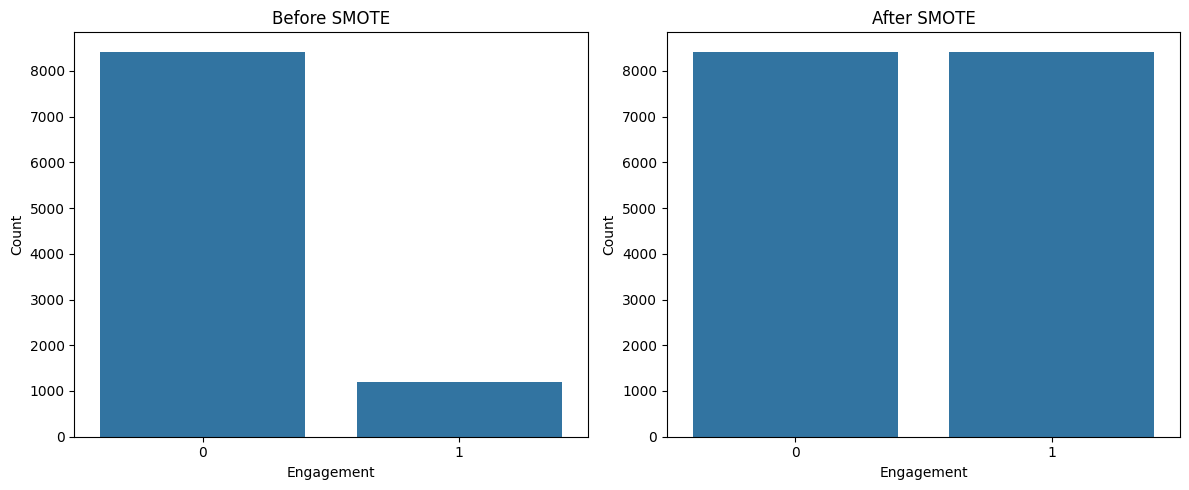

In [17]:
import pyreadstat
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "ATP W89.sav"
df, meta = pyreadstat.read_sav(file_path)
# print(df.shape) # 164 columns

# initial filtering: drop clearly irrelevant
# keep columns with personal/demographic data, useful social media habits, target
df = df.drop(columns=["QKEY"])
interview_data = [x for x in df.columns if ("INTERVIEW" in x or "DEVICE" in x or "FORM" in x)] # asked ChatGPT for example subsetting list based on element values
df = df.drop(columns=interview_data)
# our target: how engaged individuals were
target = "ENGACTCT_W89"
# 2 features about social media habits selected from examining meaning in questionnaire/their metadata labels
sm_features = ["CLIMSEEK_W89","FOLCLIM_W89"]
# no longer need other questionnaire data, only using ENGACTCT to measure engagement, two social media habit cols relevant, personal data
personal_data = [x for x in df.columns if ("W89" not in x)]
keep_columns = personal_data + sm_features + [target]
df = df.loc[:,keep_columns]


def get_feat_vals_labels(column):
    print(df[column].value_counts())
    print(meta.variable_value_labels.get(column))

def get_na_columns():
    na_counts = pd.DataFrame({"na":df.isna().apply(sum)})
    na_columns = na_counts.loc[na_counts["na"]>0]
    return na_columns

# na_columns = get_na_columns()
# for col in na_columns.index:
#     get_feat_vals_labels(col)
df = df.drop(columns=["F_BORN","F_PARTYLN_FINAL"]) # dropped these columns b/c high proportion of NaNs & exist at least 1 other complete col describing similar data

# impute missing vals and 99.0s ('Refused') with mode
na_cols = get_na_columns().index
for i in range(len(df.columns)):
    column = df.columns[i]
    col_mode = df[column].mode()[0]
    if(column in na_cols):
        df[column] = df[column].fillna(col_mode)
    df[column] = df[column].apply(lambda x: col_mode if x==99.0 else x) # treat 99.0 ("Refused") as missing val
    # print(df[column].value_counts()) # verify no 99.0s remain

# Also want to recode the target feature -> target column name, values more interpretable:
df = df.rename(columns={"ENGACTCT_W89":"Engagement"})
df["Engagement"] = df["Engagement"].apply(lambda x: 1 if x>=2.0 else 0) # 1 represents active/engaged, 0 not

# Check for imbalances
print(df["Engagement"].value_counts()) # need to resample

# create train-test splits before resampling
target = df["Engagement"]
feat_df = df.drop(columns=["Engagement"])
X_train, X_test, y_train, y_test = train_test_split(
    feat_df, target, test_size=0.3, random_state=42, stratify=target
)

# run SMOTE
smote = SMOTE(random_state=3001)
print(X_train.shape,y_train.shape)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)
print(X_train_balanced.shape,y_train_balanced.shape) # fix oversampling, then remember the recoding of target into >2, <=2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Engagement")
axes[0].set_ylabel("Count")

# Plot after SMOTE
sns.countplot(x=y_train_balanced, ax=axes[1])
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Engagement")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
# Ready for PCA: missing vals addressed, all cols encoded, no need to scale b/c encoding addresses scale (e.g. income ranges instead of raw incomes), sampling done for imbalance

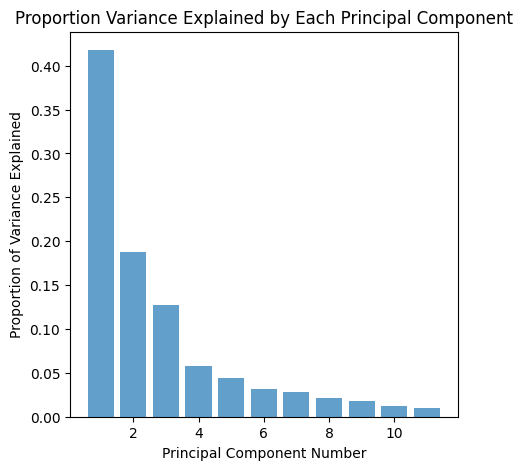

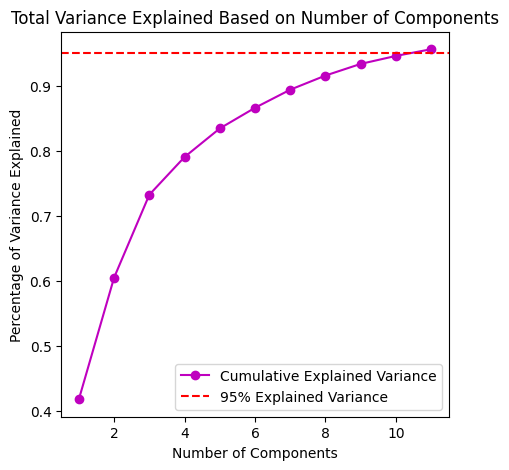

                      Cum_feature_weight
F_METRO                         0.092908
F_CITIZEN                       0.131456
CLIMSEEK_W89                    0.142398
F_REG                           0.250627
F_HISP                          0.279945
F_INC_TIER2                     0.282474
F_GENDER                        0.285303
F_VOLSUM                        0.358848
FOLCLIM_W89                     0.387387
F_RELIGCAT1                     0.485637
F_CREGION                       0.514984
F_INTFREQ                       0.633353
F_EDUCCAT                       1.127885
F_CDIVISION                     1.251275
F_PARTYSUMIDEO_FINAL            1.383759
F_YEARSINUS                     1.429594
F_AGECAT                        1.473733
F_RACETHNMOD                    1.502492
F_INC_SDT1                      1.518882
F_RELIG                         1.547787
F_RACECMB                       1.561557
F_GENERATIONS                   1.564922
F_PARTY_FINAL                   1.568227
F_BIRTHPLACE    

In [18]:
# PCA:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
def fit_pca(num_comp):
    pca = PCA(n_components=num_comp)
    pca.fit_transform(X_train_balanced)
    return pca

def plot_pc_proportions(pca):
    pca_var_proportions = pca.explained_variance_ratio_
    plt.figure(figsize=[5,5])
    plt.bar(range(1,len(pca_var_proportions)+1),pca_var_proportions, alpha=0.7) #x-axis is PC #, y-axis is proportion of variance that PC explains
    plt.xlabel("Principal Component Number")
    plt.ylabel("Proportion of Variance Explained")
    plt.title("Proportion Variance Explained by Each Principal Component")
    return pca_var_proportions

def plot_cumulative_var(pca_var_proportions):
    cumulative_var = np.cumsum(pca_var_proportions) #each element is sum of any prev proportions + current
    plt.figure(figsize=[5,5])
    plt.plot(range(1,len(cumulative_var)+1),cumulative_var,marker='o',linestyle='-',color='m',label='Cumulative Explained Variance') # modeled after class pca notebook
    plt.xlabel("Number of Components")
    plt.ylabel("Percentage of Variance Explained")
    plt.title("Total Variance Explained Based on Number of Components")
    plt.axhline(y=0.95,color='r',linestyle='--',label="95% Explained Variance")
    plt.legend()
    plt.show()


pca = fit_pca(11) # adjustest arg until threshold reached: need 11 components to explain 95% variance
proportions = plot_pc_proportions(pca)
plot_cumulative_var(proportions)

initial_cum_weights = np.zeros(len(X_train_balanced.columns)) # asked ChatGPT how to make a zero-initialized array
cum_weight_df = pd.DataFrame({"Cum_feature_weight":initial_cum_weights})
cum_weight_df.index = X_train_balanced.columns

for i in range(0,11):
    pc = pca.components_[i]
    pc_df = pd.DataFrame({"Proportion of PC Calculation":pc})
    pc_df = pc_df.apply(abs)
    pc_df.index = X_train_balanced.columns

    for column in X_train_balanced.columns:
        rel_importance = pc_df.loc[column,"Proportion of PC Calculation"]
        cum_weight_df.loc[column,"Cum_feature_weight"] += rel_importance

cum_weight_df = cum_weight_df.sort_values(by="Cum_feature_weight")
print(cum_weight_df)

# Reduce dimensionality based on cumulative importance derived from PCA
# drop lowest-weight repeat feats ("F_RELIGCAT1", "F_INC_TIER2"), other lowest-weight (F_metro,F_citizen,F_reg,F_Cregion)
X_train_balanced = X_train_balanced.drop(columns=["F_RELIGCAT1","F_INC_TIER2","F_METRO","F_CITIZEN","F_REG","F_CREGION"])
X_test = X_test.drop(columns=["F_RELIGCAT1","F_INC_TIER2","F_METRO","F_CITIZEN","F_REG","F_CREGION"])

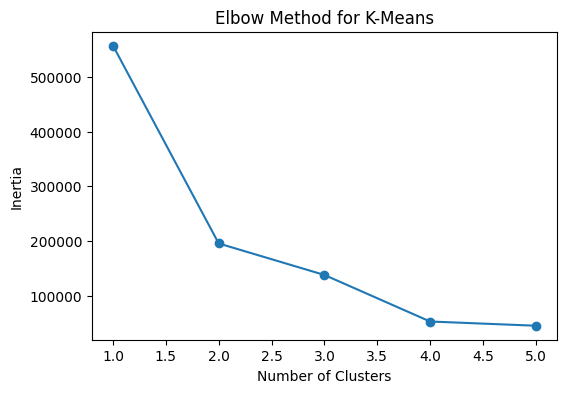

Cluster                      0          1
F_CDIVISION           5.086041   5.456373
F_AGECAT              2.716340   2.472253
F_GENDER              1.598995   1.562647
F_EDUCCAT             1.569205   1.458987
F_EDUCCAT5            3.674205   3.830136
F_HISP                1.823330   1.870668
F_YEARSINUS           1.299402   1.271190
F_RACECMB             1.402531   1.424671
F_RACETHNMOD          1.614372   1.610594
F_BIRTHPLACE          1.371889   1.330424
F_RELIG               1.618819  10.700481
F_ATTEND              3.421809   5.415812
F_PARTY_FINAL         2.163388   2.472488
F_PARTYSUM_FINAL      1.772458   2.012923
F_PARTYSUMIDEO_FINAL  2.804457   3.606936
F_INC_SDT1            5.514529   5.536457
F_IDEO                2.945478   3.838177
F_INTFREQ             1.670306   1.526884
F_VOLSUM              1.464186   1.501708
F_GENERATIONS         3.782412   4.069176
CLIMSEEK_W89          1.879177   1.847330
FOLCLIM_W89           1.762916   1.605505


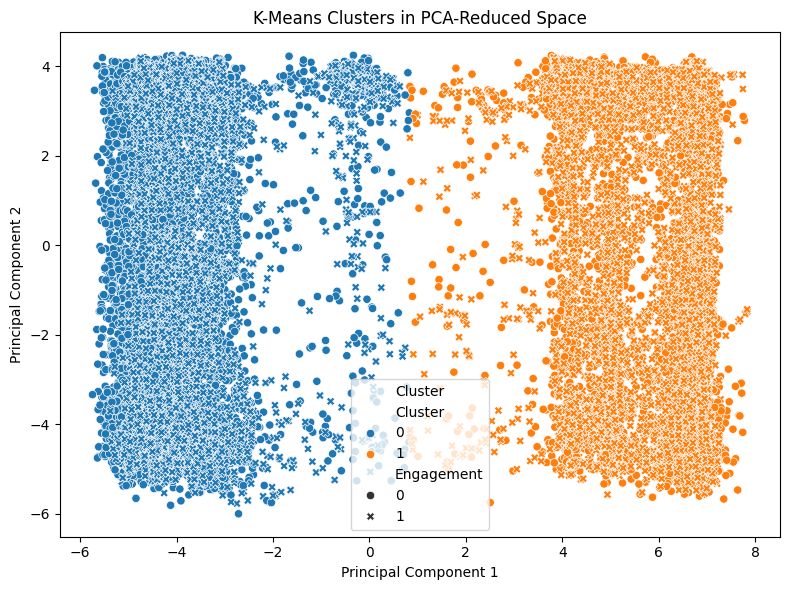

Correlation between clusters and engagement: 0.18958371887284906


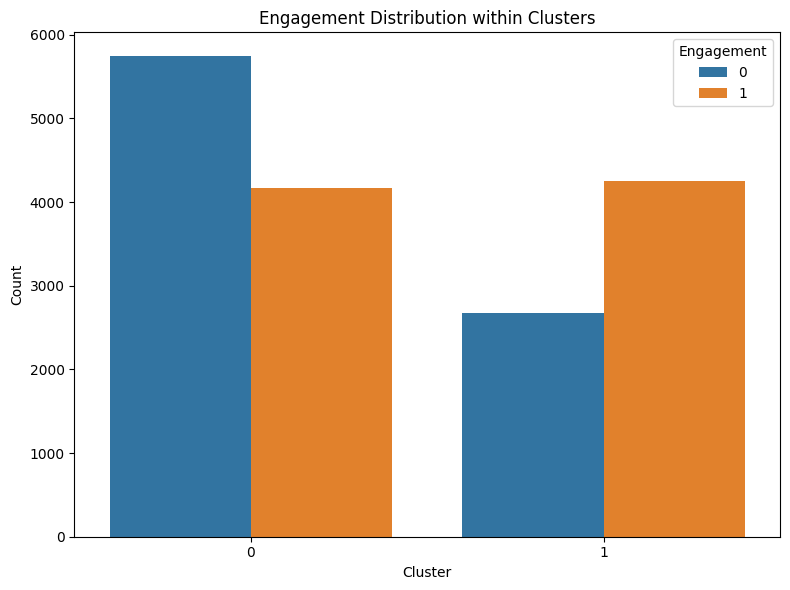

In [19]:
# K-means clustering
# Using to see patterns in social media behavior that might not directly relate to climate engagement labels
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#pca for dimentionality 
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_balanced)

# elbow plot to determine optimal number of clusters
inertia = []
k_vals = range(1, 6)
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca_2d)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_vals, inertia, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# using k=2 based on elbow plot and other trials with different k-values
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_2d)

clustered_df = X_train_balanced.copy()
clustered_df["Cluster"] = clusters
cluster_means = clustered_df.groupby("Cluster").mean()
print(cluster_means.T)

# combine for plotting
pca_df = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters
pca_df["Engagement"] = y_train_balanced.reset_index(drop=True)
#asked chat gpt how to incorporate engagement to the pca data frome 

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", style="Engagement")
plt.title("K-Means Clusters in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# see if there's any correlation between the different clusters and those more engaged 
correlation = pca_df["Cluster"].corr(pca_df["Engagement"])
print(f"Correlation between clusters and engagement: {correlation}")

# graphs to visualize the distributions of engagement 
plt.figure(figsize=(8,6))
sns.countplot(data=pca_df, x="Cluster", hue="Engagement", palette="tab10")
plt.title("Engagement Distribution within Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Engagement")
plt.tight_layout()
plt.show()


Cluster 0:
Slightly older

Slightly more liberal

Less religious

A bit more likely to follow climate orgs


Cluster 1:
Younger

More conservative

Significantly more religious (possibly weekly churchgoers)

Slightly higher education

Slightly less climate engagement

Decision Tree Best Estimator Parameters:
   max_depth  min_samples_split  min_samples_leaf
0      None                 10                 4
Random Forest Best Estimator Parameters:
    n_estimators max_depth  min_samples_split  min_samples_leaf
0           100      None                  5                 1
Decision Tree, Train Set
Accuracy: 0.9504156769596199
F1 Score (macro): 0.95039133861716
F1 Score (weighted): 0.9503913386171599
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      8420
           1       0.97      0.93      0.95      8420

    accuracy                           0.95     16840
   macro avg       0.95      0.95      0.95     16840
weighted avg       0.95      0.95      0.95     16840



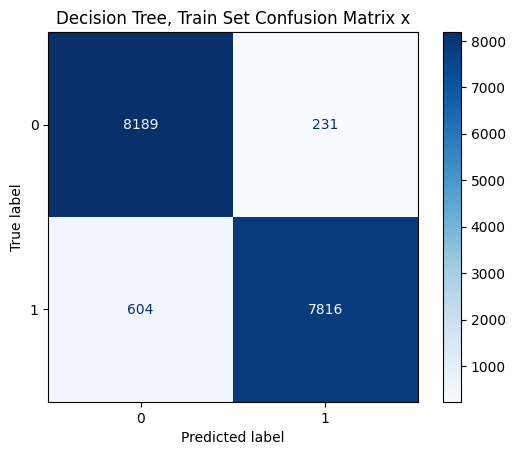

Decision Tree, Test Set
Accuracy: 0.8363636363636363
F1 Score (macro): 0.5827382084346563
F1 Score (weighted): 0.8266634101088899
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      3609
           1       0.30      0.23      0.26       516

    accuracy                           0.84      4125
   macro avg       0.60      0.58      0.58      4125
weighted avg       0.82      0.84      0.83      4125



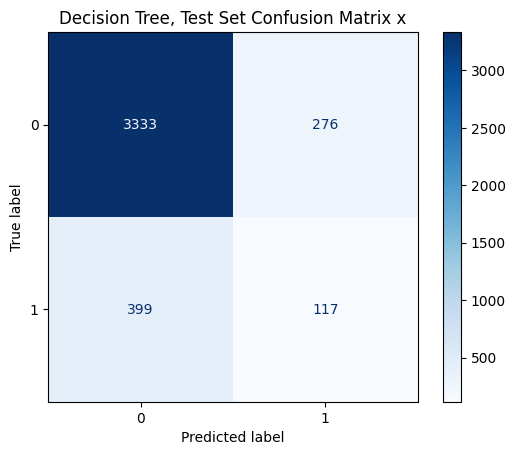

Random Forest (custom threshold), Train Set
Accuracy: 0.9925178147268409
F1 Score (macro): 0.9925177319850074
F1 Score (weighted): 0.9925177319850074
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8420
           1       0.99      1.00      0.99      8420

    accuracy                           0.99     16840
   macro avg       0.99      0.99      0.99     16840
weighted avg       0.99      0.99      0.99     16840



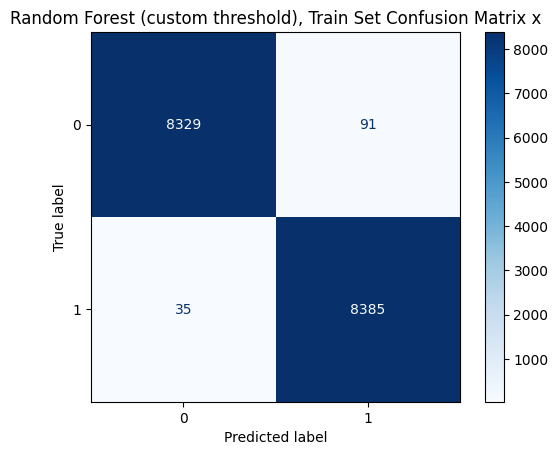

Random Forest (custom threshold), Test Set
Accuracy: 0.8487272727272728
F1 Score (macro): 0.6443521350478121
F1 Score (weighted): 0.8465050934240742
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      3609
           1       0.39      0.36      0.37       516

    accuracy                           0.85      4125
   macro avg       0.65      0.64      0.64      4125
weighted avg       0.84      0.85      0.85      4125



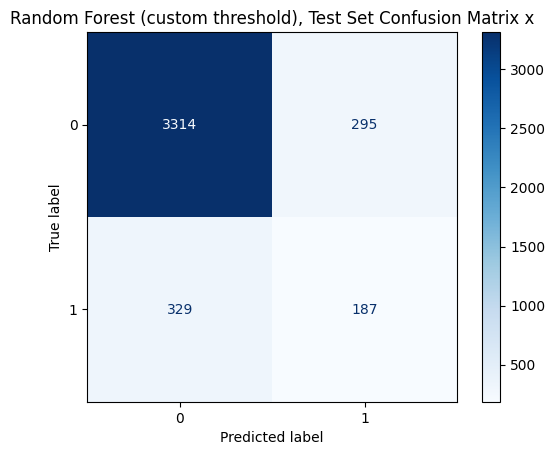

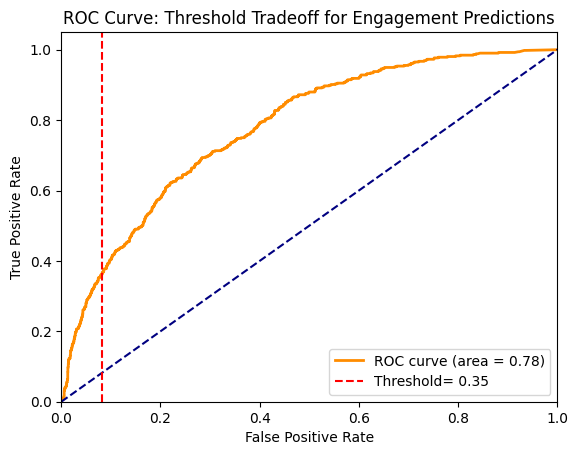

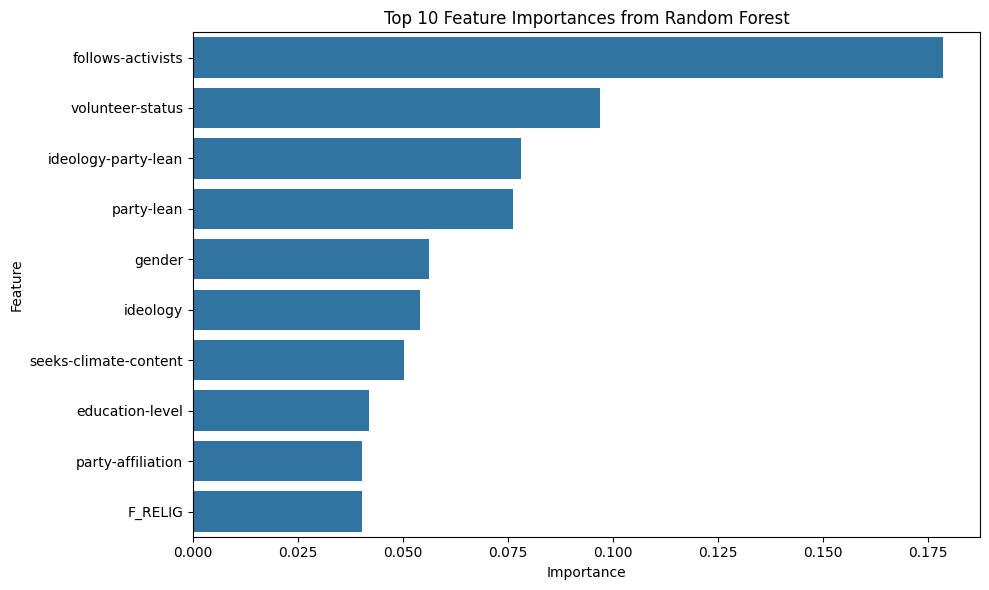

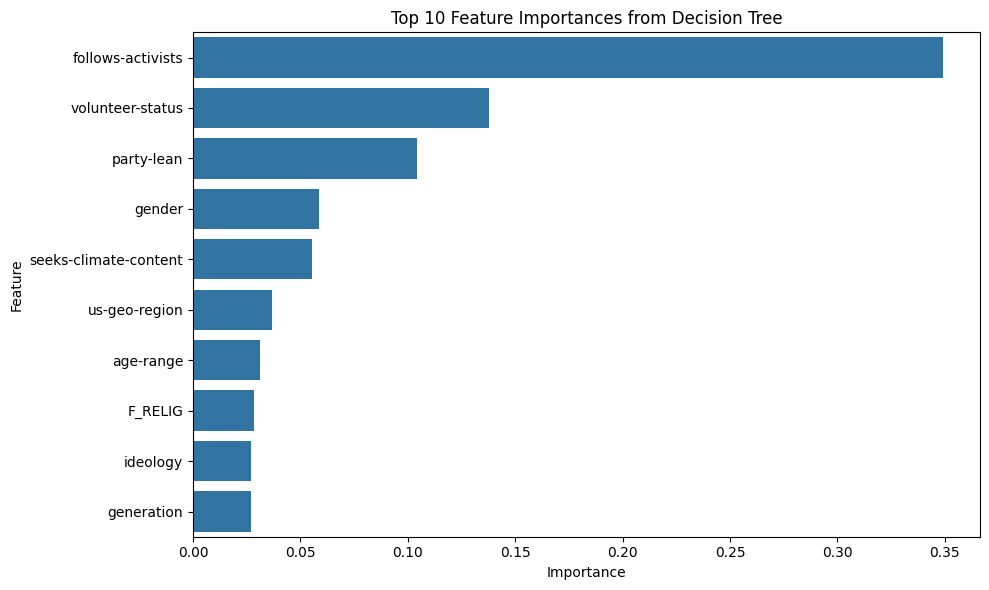

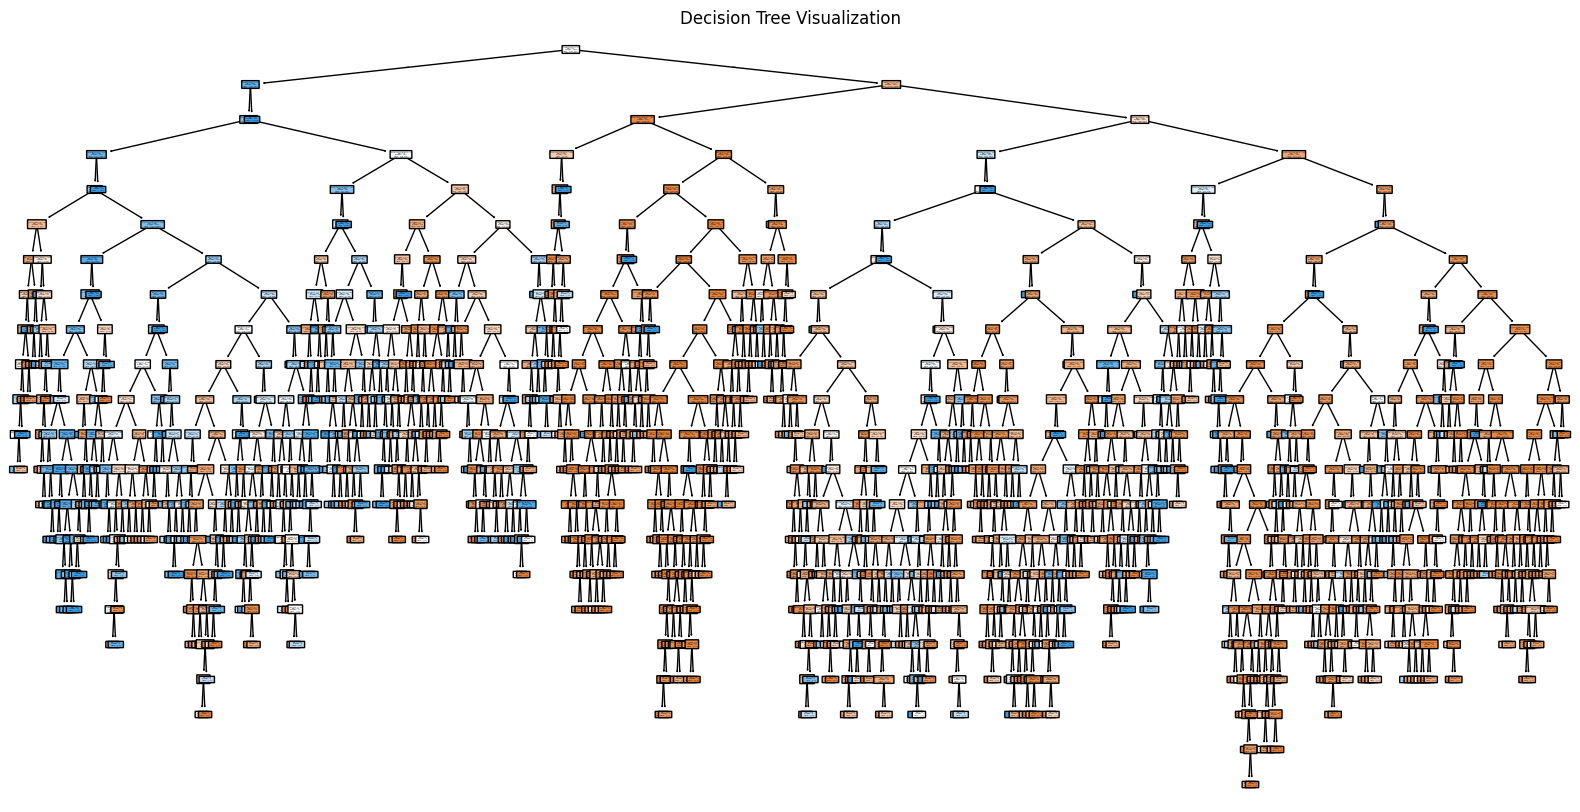

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#changes made during tuning to get better results in the takes action group are shown through comments w/ old version and explination of change made 
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# dt = DecisionTreeClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')  # Added class weighting to improve model for takes action group

# dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_weighted')
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_macro')  # Changed scoring to focus on balanced performance

dt_grid.fit(X_train_balanced, y_train_balanced)
dt_best = dt_grid.best_estimator_
dt_arr_params = dt_best.get_params()
dt_params = pd.DataFrame({"max_depth":dt_arr_params["max_depth"],"min_samples_split":dt_arr_params["min_samples_split"],"min_samples_leaf":dt_arr_params["min_samples_leaf"]},index=[0])
print("Decision Tree Best Estimator Parameters:\n",dt_params)
y_pred_dt_test = dt_best.predict(X_test)
y_pred_dt_train = dt_best.predict(X_train_balanced)


rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# rf = RandomForestClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')  # Added class weighting

# rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_weighted')
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_macro')  # Changed scoring to macro F1 so that the model might better focus on the takes action group as well as the no action group even though we did already balance them through SMOTE

rf_grid.fit(X_train_balanced, y_train_balanced)
rf_best = rf_grid.best_estimator_
rf_arr_params = rf_best.get_params()
rf_params = pd.DataFrame({"n_estimators":rf_arr_params["n_estimators"],"max_depth":rf_arr_params["max_depth"],"min_samples_split":rf_arr_params["min_samples_split"],"min_samples_leaf":rf_arr_params["min_samples_leaf"]},index=[0])
print("Random Forest Best Estimator Parameters:\n",rf_params)

# y_pred_rf = rf_best.predict(X_test)
y_proba_rf_test = rf_best.predict_proba(X_test)[:, 1]  # Use probabilities to apply custom threshold
threshold = 0.35  # Lower threshold to boost recall for class 1 so that classification of what counts as engaged isn't too strict
y_pred_rf_test = (y_proba_rf_test >= threshold).astype(int)

# compare with training set performance to check for overfitting
y_proba_rf_train = rf_best.predict_proba(X_train_balanced)[:, 1]
threshold = 0.35
y_pred_rf_train = (y_proba_rf_train >= threshold).astype(int)

def evaluate_model(name, y_test, y_pred):
    print(name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
    print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix x")
    plt.show()

evaluate_model("Decision Tree, Train Set", y_train_balanced, y_pred_dt_train)
evaluate_model("Decision Tree, Test Set", y_test, y_pred_dt_test)
evaluate_model("Random Forest (custom threshold), Train Set", y_train_balanced, y_pred_rf_train)
evaluate_model("Random Forest (custom threshold), Test Set", y_test, y_pred_rf_test)

# ROC curve to evaluate TPR/FPR tradeoff:
def plotROC(check_threshold):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf_test)
    roc_auc = auc(fpr,tpr)
    threshold_index = np.argmin(np.abs(thresholds-check_threshold)) # asked chatGPT how to find closest matching val in arr
    fpr_threshold = fpr[threshold_index]

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axvline(x=fpr_threshold, color='r',linestyle='--',label=f'Threshold= {check_threshold:.2f}')  # asked chatGPT how to plot vertical line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Threshold Tradeoff for Engagement Predictions')
    plt.legend(loc="lower right")
    plt.show()

plotROC(0.35) # adjusted rf above based on tested thresholds

# for recoding most important features (after observed them below)
X_train_balanced.rename(columns={"FOLCLIM_W89":"follows-activists"},inplace=True)
X_train_balanced.rename(columns={"F_VOLSUM":"volunteer-status"},inplace=True)
X_train_balanced.rename(columns={"F_PARTYSUMIDEO_FINAL":"ideology-party-lean"},inplace=True)
X_train_balanced.rename(columns={"F_PARTYSUM_FINAL":"party-lean"},inplace=True)
X_train_balanced.rename(columns={"F_GENDER":"gender"},inplace=True)
X_train_balanced.rename(columns={"F_IDEO":"ideology"},inplace=True)
X_train_balanced.rename(columns={"CLIMSEEK_W89":"seeks-climate-content"},inplace=True)
X_train_balanced.rename(columns={"F_EDUCCAT5":"education-level"},inplace=True)
X_train_balanced.rename(columns={"F_PARTY_FINAL":"party-affiliation"},inplace=True)
X_train_balanced.rename(columns={"F_CDIVISION":"us-geo-region"},inplace=True)
X_train_balanced.rename(columns={"F_AGECAT":"age-range"},inplace=True)
X_train_balanced.rename(columns={"F_GENERATIONS":"generation"},inplace=True)
X_train_balanced.rename(columns={"F_RELIG":"religion"},inplace=True)

# Random Forest feature importances
importances_rf = rf_best.feature_importances_
feat_names = X_train_balanced.columns
importance_df_rf = pd.DataFrame({'Feature': feat_names, 'Importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Decision Tree feature importances
importances_dt = dt_best.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': feat_names, 'Importance': importances_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_dt.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances from Decision Tree")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(
    dt_best,
    feature_names=feat_names,
    class_names=["No Action", "Takes Action"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()
